# Bayesian Model Selection

Authors: Yuchen Zhou and Audrey Olivier - 12/10/2018 <br>
Last modified by Audrey Olivier on 12/13/2018

## Quick review of Bayesian model selection

The problem of model selection consists in determining which model(s) best explain the available data $D$, given a set of candidate models $m_{1:M}$. Each model $m_{j}$ is parameterized by a set of parameters $\theta_{m_{j}} \in \Theta_{m_{j}}$, to be estimated based on data. In the Bayesian framework, model selection is perfomed by computing the posterior probability of each model $m_{j}$ using Bayes' theorem:

$$P(m_{j} \vert D) = \frac{p(D \vert m_{j})P(m_{j})}{\sum_{j=1}^{M} P(D \vert m_{j})P(m_{j})}$$

where $P(m_{j})$ is the prior assigned to model $m_{j}$ and $P(D \vert m_{j})$ is the model evidence, also called marginal likelihood.

$$ p(D \vert m_{j}) = \int_{\Theta_{m_{j}}} p(D \vert m_{j}, \theta_{m_{j}}) p(\theta_{m_{j}} \vert m_{j}) d\theta_{m_{j}} $$

where $p(\theta_{m_{j}} \vert m_{j})$ is the prior assigned to the parameter vector of model $m_{j}$.

## Numerical example

In the following we present an example for which the posterior pdf of the parameters, evidences and model probabilities can be computed analytically. We drop the $m_{j}$ subscript when referring to model parameters for simplicity. Three models are considered (the domain $x$ is fixed and consists in 50 equally spaced points):
\begin{align*}
m_{linear}:& \quad y = \theta_{0} x + \epsilon \\
m_{quadratic}:& \quad y = \theta_{0} x + \theta_{1} x^2 + \epsilon \\
m_{cubic}:& \quad y = \theta_{0} x + \theta_{1} x^2+ \theta_{2} x^3 + \epsilon \\
\end{align*}

All three models can be written in a compact form as $y=X \theta + \epsilon$, where $X$ contains the necessary powers of $x$. For all three models, the prior is chosen to be Gaussian, $p(\theta) = N(\cdot, \theta_{prior}, \Sigma_{prior})  $, and so is the noise $\epsilon \sim N(\cdot; 0, \sigma_{n}^{2} I)$. Then the posterior of the parameters can be computed analytically as:

\begin{align*}
& p(\theta \vert D={x,y}) =  N(\cdot; \theta_{post}(D), \Sigma_{post}(D)) \\
& \theta_{post}(D) = \left( \frac{1}{\sigma_{n}^{2}}X^{T}X + \Sigma_{prior}^{-1} \right)^{-1} \left(\frac{1}{\sigma_{n}^{2}}X^{T}y+\Sigma^{-1}\theta_{prior} \right) \\
& \Sigma_{post}(D) = \left( \frac{1}{\sigma_{n}^{2}}X^{T}X + \Sigma_{prior}^{-1} \right)^{-1}
\end{align*}

Then the evidence of each model can be computed as 

$$ p(D) = \frac{p(D \vert \theta)p(\theta)}{p(\theta \vert D)} $$
where $p(D \vert \theta) = N(\cdot; X\theta, \sigma_{n}^{2} I)$, $p(\theta) = N(\cdot, \theta_{prior}, \Sigma_{prior}) $ and $p(\theta \vert D) = N(\cdot, \theta_{post}(D), \Sigma_{post}(D))$. This formula can be computed at any point $\theta$.

### Generate data from the quadratic model

In [1]:
# import necessary packages
import numpy as np
import matplotlib.pyplot as plt
from UQpy.Inference import *
from UQpy.RunModel import RunModel # required to run the quadratic model
from sklearn.neighbors import KernelDensity # for the plots
from statsmodels.nonparametric.kde import KDEUnivariate

In [2]:
# Generate data from a quadratic function
import random
random.seed(8) #set seed for reproducibility
from scipy.stats import multivariate_normal
param_true = np.array([1.0, 2.0]).reshape(1, -1)
var_n = 1
error_covariance = var_n*np.eye(50)
print(param_true.shape)

z = RunModel(samples=param_true, model_script='pfn_models.py', model_object_name = 'model_quadratic', 
             var_names = ['theta_1', 'theta_2'])
data = z.qoi_list[0].reshape((-1,))+multivariate_normal.rvs(mean=None, cov=error_covariance, size=1)
print(data)

(1, 2)
[-1.74602981e+00  7.81838633e-02  1.64408403e+00  2.05169792e+00
  1.26006917e+00  3.46597873e+00  3.30533097e+00  3.28427911e+00
  6.10132177e+00  9.60533125e+00  1.06487082e+01  1.26888973e+01
  1.52607730e+01  1.67557530e+01  1.90254037e+01  1.90774227e+01
  2.18352988e+01  2.69926693e+01  2.93527448e+01  3.36649514e+01
  3.81368831e+01  4.26983670e+01  4.52144059e+01  4.80587461e+01
  5.37153459e+01  5.52173547e+01  6.04758546e+01  6.70799451e+01
  7.20716035e+01  7.47716939e+01  8.14595382e+01  8.58525977e+01
  9.13623287e+01  9.71680003e+01  1.03676989e+02  1.08015803e+02
  1.13263052e+02  1.22295820e+02  1.27397503e+02  1.36261472e+02
  1.40434843e+02  1.48423916e+02  1.55348991e+02  1.62816284e+02
  1.69924911e+02  1.77446585e+02  1.86006579e+02  1.95214599e+02
  2.02441512e+02  2.09362903e+02]


### Define the models, compute the true values of the evidence.

For all three models, a Gaussian prior is chosen for the parameters, with mean and covariance matrix of the appropriate dimensions. Each model is given prior probability $P(m_{j}) = 1/3$.

In [3]:
# Define the models
model_names = ['model_linear', 'model_quadratic', 'model_cubic']
model_n_params = [1, 2, 3]
model_prior_means = [[0], [0,0], [0,0,0]]
model_prior_stds = [[10], [1,1], [1,2,0.25]]

In [4]:
evidences = []
model_posterior_means = []
model_posterior_stds = []
for n, model in enumerate(model_names):
    # compute matrix X
    X = np.linspace(0, 10, 50).reshape((-1,1))
    if n == 1: # quadratic model
        X = np.concatenate([X, X**2], axis=1)
    if n == 2: # cubic model
        X = np.concatenate([X, X**2, X**3], axis=1)

    # compute posterior pdf
    m_prior = np.array(model_prior_means[n]).reshape((-1,1))
    S_prior = np.diag(np.array(model_prior_stds[n])**2)
    S_posterior = np.linalg.inv(1/var_n*np.matmul(X.T,X)+np.linalg.inv(S_prior))
    m_posterior = np.matmul(S_posterior, 
                            1/var_n*np.matmul(X.T, data.reshape((-1,1)))+np.matmul(np.linalg.inv(S_prior),m_prior))
    m_prior = m_prior.reshape((-1,))
    m_posterior = m_posterior.reshape((-1,))
    model_posterior_means.append(list(m_posterior))
    model_posterior_stds.append(list(np.sqrt(np.diag(S_posterior))))
    print('posterior mean and covariance for '+model)
    print(m_posterior, S_posterior)
    
    # compute evidence, evaluate the formula at the posterior mean
    like_theta = multivariate_normal.pdf(data, mean=np.matmul(X,m_posterior).reshape((-1,)), cov=error_covariance)
    prior_theta = multivariate_normal.pdf(m_posterior, mean=m_prior, cov=S_prior)
    posterior_theta = multivariate_normal.pdf(m_posterior, mean=m_posterior, cov=S_posterior)
    evidence = like_theta*prior_theta/posterior_theta
    evidences.append(evidence)
    print('evidence for '+model+'= {}\n'.format(evidence))
    
# compute the posterior probability of each model
tmp = [1/3*evidence for evidence in evidences]
model_posterior_probas = [p/sum(tmp) for p in tmp]

print('posterior probabilities of all three models')
print(model_posterior_probas)

posterior mean and covariance for model_linear
[16.13094079] [[0.00059394]]
evidence for model_linear= 0.0

posterior mean and covariance for model_quadratic
[0.81307907 2.02190665] [[ 0.00941698 -0.00116538]
 [-0.00116538  0.00015392]]
evidence for model_quadratic= 3.123862430408772e-37

posterior mean and covariance for model_cubic
[ 7.43348116e-01  2.04470726e+00 -1.68190147e-03] [[ 5.60383740e-02 -1.66457308e-02  1.15371992e-03]
 [-1.66457308e-02  5.29411877e-03 -3.83090725e-04]
 [ 1.15371992e-03 -3.83090725e-04  2.85512405e-05]]
evidence for model_cubic= 1.6253300620005584e-38

posterior probabilities of all three models
[0.0, 0.9505436855256314, 0.04945631447436852]


### Define the models for use in UQpy

In [5]:
# Define models
candidate_models = []
for n, model_name in enumerate(model_names):
    model = Model(n_params=model_n_params[n], model_type='python', 
                  model_script='pfn_models.py', model_object_name = model_name,
                  prior_name = ['normal']*model_n_params[n], 
                  prior_params = [[m, std] for (m,std) in zip(model_prior_means[n], model_prior_stds[n])],
                  error_covariance=error_covariance,
                  model_name=model_name)
    candidate_models.append(model)

### Run MCMC for all three models

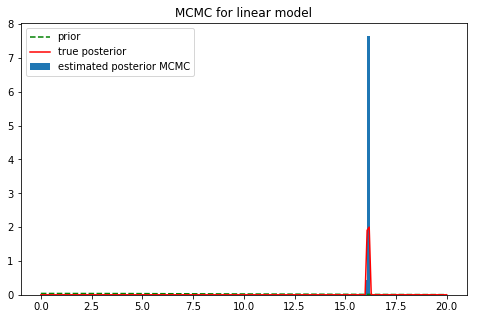

In [6]:
# Linear model
from scipy.stats import norm

bayesMCMC = BayesParameterEstimation(data=data, model=candidate_models[0], sampling_method = 'MCMC', nsamples=1200,
                                     algorithm = 'MH', jump=10, nburn=100, pdf_proposal = 'Normal',
                                     pdf_proposal_scale = [0.1], 
                                     seed = model_prior_means[0]
                                     )
# plot prior, true posterior and estimated posterior
fig, ax = plt.subplots(figsize=(8,5))
domain_plot = np.linspace(0,20,200)
ax.plot(domain_plot, norm.pdf(domain_plot, loc=model_prior_means[0], scale=model_prior_stds[0]),
            label = 'prior', color='green', linestyle='--')
ax.plot(domain_plot, norm.pdf(domain_plot, loc=model_posterior_means[0], 
                                  scale=model_posterior_stds[0]),
            label = 'true posterior', color='red', linestyle='-')
ax.hist(bayesMCMC.samples[:,0], density=True, bins=100, label='estimated posterior MCMC')
plt.legend()
plt.title('MCMC for linear model')
plt.show(fig)

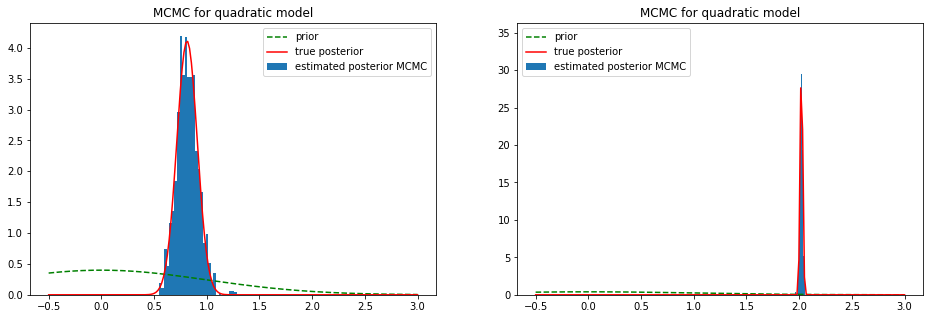

In [7]:
# Quadratic system
bayesMCMC = BayesParameterEstimation(data=data, model=candidate_models[1], sampling_method = 'MCMC', nsamples=3500,
                                     algorithm = 'MH', jump=10, nburn=100, pdf_proposal = 'Normal',
                                     pdf_proposal_scale = [0.1, 0.1], 
                                     seed = model_prior_means[1]
                                     )
# plot prior, true posterior and estimated posterior
fig, ax = plt.subplots(1,2,figsize=(16,5))
for n_p in range(2):
    domain_plot = np.linspace(-0.5,3,200)
    ax[n_p].plot(domain_plot, norm.pdf(domain_plot, loc=model_prior_means[1][n_p], scale=model_prior_stds[1][n_p]),
                label = 'prior', color='green', linestyle='--')
    ax[n_p].plot(domain_plot, norm.pdf(domain_plot, loc=model_posterior_means[1][n_p], 
                                      scale=model_posterior_stds[1][n_p]),
                label = 'true posterior', color='red', linestyle='-')
    ax[n_p].hist(bayesMCMC.samples[:,n_p], density=True, bins=30, label='estimated posterior MCMC')
    ax[n_p].legend()
    ax[n_p].set_title('MCMC for quadratic model')
plt.show(fig)

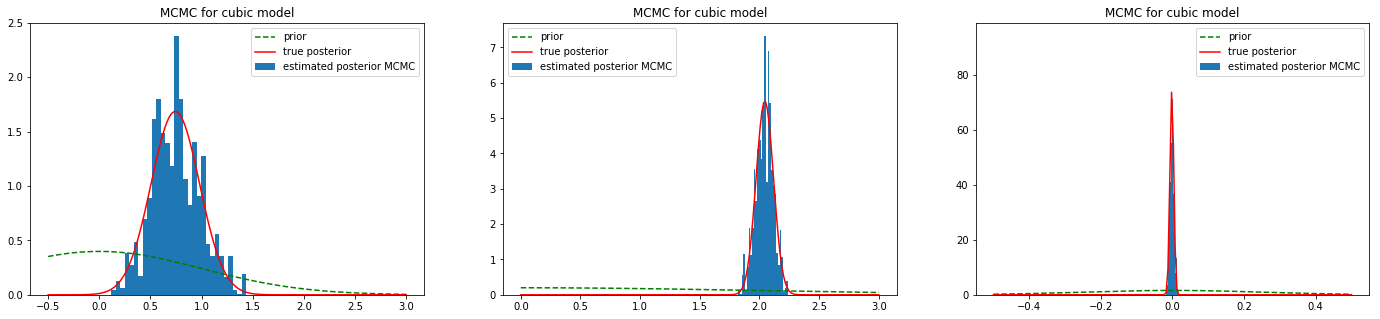

In [8]:
# Cubic system
domain_plot = [np.linspace(-0.5,3,200), np.linspace(0,3,200), np.linspace(-0.5,0.5,200)]

bayesMCMC = BayesParameterEstimation(data=data, model=candidate_models[2], sampling_method = 'MCMC', nsamples=12000,
                                     algorithm = 'MH', jump=30, nburn=500, pdf_proposal = 'Normal',
                                     pdf_proposal_scale = [0.15, 0.1, 0.05], 
                                     seed = model_prior_means[2]
                                     )
# plot prior, true posterior and estimated posterior
fig, ax = plt.subplots(1,3,figsize=(24,5))
for n_p in range(3):
    ax[n_p].plot(domain_plot[n_p], norm.pdf(domain_plot[n_p], loc=model_prior_means[2][n_p], 
                                            scale=model_prior_stds[2][n_p]),
                label = 'prior', color='green', linestyle='--')
    ax[n_p].plot(domain_plot[n_p], norm.pdf(domain_plot[n_p], loc=model_posterior_means[2][n_p], 
                                      scale=model_posterior_stds[2][n_p]),
                label = 'true posterior', color='red', linestyle='-')
    ax[n_p].hist(bayesMCMC.samples[:,n_p], density=True, bins=30, label='estimated posterior MCMC')
    ax[n_p].legend()
    ax[n_p].set_title('MCMC for cubic model')
plt.show(fig)

### Run Bayesian Model Selection for all three models

In [9]:
# Defines constants for the MCMC learning part, same as above
algos = ['MH']*3
proposal_types=['Normal']*3
scales = [[0.1],[0.1, 0.1],[0.15, 0.1, 0.05]]
nsamples = [1200,3500,12000]
nburn = [100,100,500]
jump = [10,10,30]

In [10]:
selection = BayesModelSelection(data=data, candidate_models=candidate_models, pdf_proposal_type=proposal_types, 
                                pdf_proposal_scale=scales, algorithm=algos, jump=jump, nsamples=nsamples, nburn=nburn,  
                                prior_probabilities=[1./3., 1./3., 1./3.],
                                seed=model_prior_means, verbose=True)

UQpy: Running Bayesian MS...
UQpy: Running MCMC for model model_linear
UQpy: Running parameter estimation for candidate model  model_linear
UQpy: Parameter estimation analysis completed!
UQpy: Running MCMC for model model_quadratic
UQpy: Running parameter estimation for candidate model  model_quadratic
UQpy: Parameter estimation analysis completed!
UQpy: Running MCMC for model model_cubic
UQpy: Running parameter estimation for candidate model  model_cubic
UQpy: Parameter estimation analysis completed!
UQpy: Bayesian MS analysis completed!


In [11]:
print('Sorted models:')
print(selection.sorted_model_names)
print('Evidence of sorted models:')
print(selection.sorted_evidences)
print('Posterior probabilities of sorted models:')
print(selection.sorted_probabilities)

Sorted models:
['model_quadratic', 'model_cubic', 'model_linear']
Evidence of sorted models:
[1.4297727176333483e-33, 5.5162632671263285e-34, 0.0]
Posterior probabilities of sorted models:
[0.7215975609321478, 0.27840243906785234, 0.0]


As of version 2, the implementation of BayesModelSelection in UQpy uses the method of the harmonic mean to compute the models' evidence. This method is known to behave quite poorly, in particular it yeidls estimates with large variance. In the problem above, this implementation consistently detects that the quadratic model has the highest model probability, followed by the cubic model. However, the values of the evidence, and thus the model probabilities, are quite off and should not be trusted. Future versions of UQpy will integrate more advanced methods for the estimation of the evidence.